In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Kara = pd.read_excel(filepath, sheet_name='Kara-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Kara)
fp.date_time(Kara)

,Extent,Date
0,917992.880,1979-01-01
1,917992.880,1979-02-01
2,917992.880,1979-03-01
3,917992.880,1979-04-01
4,917992.880,1979-05-01
...,...,...
533,728642.743,2023-06-01
534,437024.646,2023-07-01
535,202260.789,2023-08-01
536,98103.856,2023-09-01


In [5]:
scaler = MinMaxScaler()
Kara['Extent'] = scaler.fit_transform(Kara['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 11
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Kara['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((516, 12, 1), (516,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Kara_model_LT11/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 40s 526ms/step - loss: 0.5933 - root_mean_squared_error: 0.7702 - val_loss: 0.3712 - val_root_mean_squared_error: 0.6093
Epoch 2/50
53/53 [==============================] - 26s 498ms/step - loss: 0.1897 - root_mean_squared_error: 0.4355 - val_loss: 0.1533 - val_root_mean_squared_error: 0.3915
Epoch 3/50
53/53 [==============================] - 27s 527ms/step - loss: 0.0927 - root_mean_squared_error: 0.3045 - val_loss: 0.1309 - val_root_mean_squared_error: 0.3618
Epoch 4/50
53/53 [==============================] - 27s 520ms/step - loss: 0.0786 - root_mean_squared_error: 0.2804 - val_loss: 0.1119 - val_root_mean_squared_error: 0.3345
Epoch 5/50
53/53 [==============================] - 28s 539ms/step - loss: 0.0649 - root_mean_squared_error: 0.2547 - val_loss: 0.0849 - val_root_mean_squared_error: 0.2913
Epoch 6/50
53/53 [==============================] - 27s 520ms/step - loss: 0.0504 - root_mean_squared_error: 0.2245 - val_loss: 0.0627 

Epoch 29/50
53/53 [==============================] - 29s 549ms/step - loss: 0.0184 - root_mean_squared_error: 0.1357 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1357
Epoch 30/50
53/53 [==============================] - 32s 621ms/step - loss: 0.0192 - root_mean_squared_error: 0.1384 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1343
Epoch 31/50
53/53 [==============================] - 29s 555ms/step - loss: 0.0186 - root_mean_squared_error: 0.1365 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1327
Epoch 32/50
53/53 [==============================] - 4s 68ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1340
Epoch 33/50
53/53 [==============================] - 28s 537ms/step - loss: 0.0162 - root_mean_squared_error: 0.1271 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1310
Epoch 34/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0170 - root_mean_squared_error: 0.1303 - val_loss: 0.017

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

15.716282836596172 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

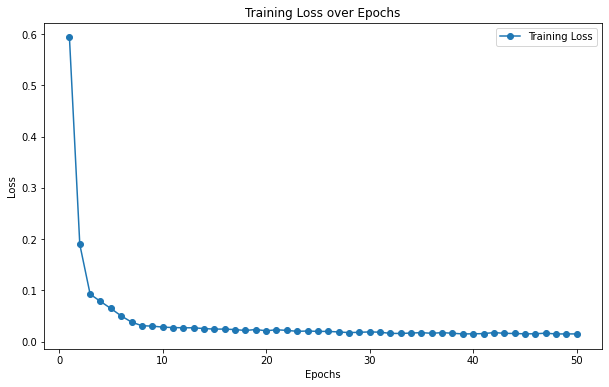

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

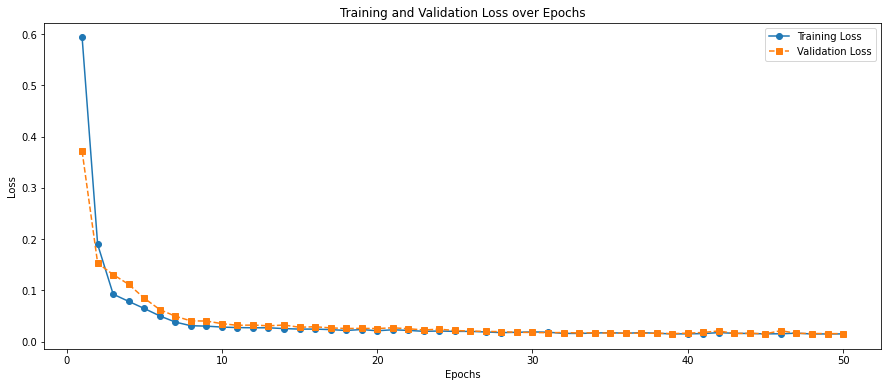

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Kara_model_LT11/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 33ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.140376556155787
MAE : 0.09671732053263575


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

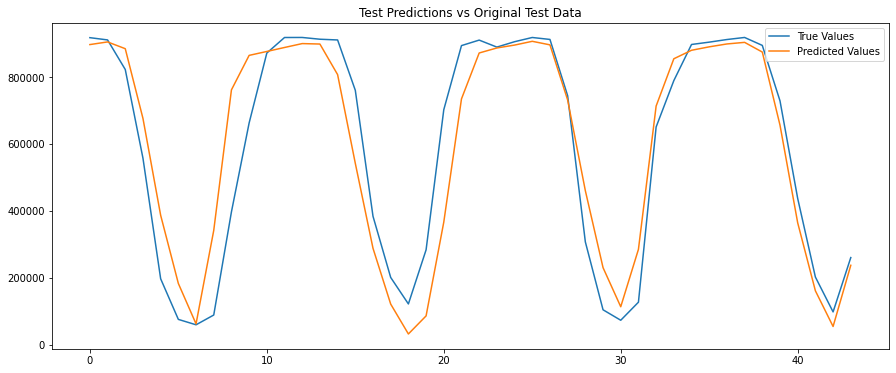

In [19]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [20]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 46ms/step


In [21]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

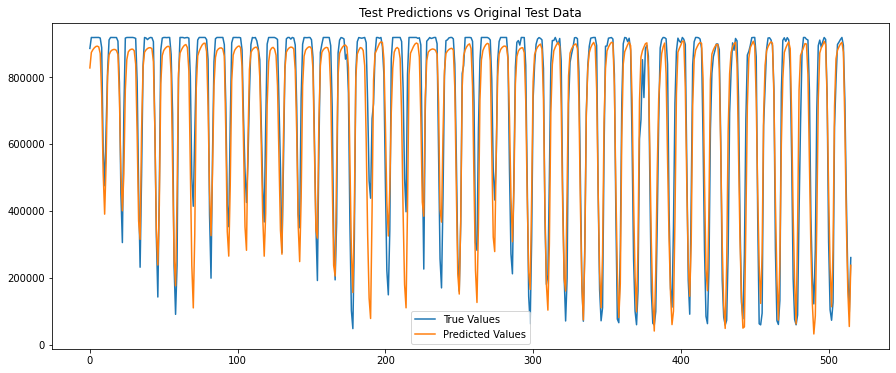

In [22]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()